In [7]:

from google.colab import files
import zipfile
import os

uploaded = files.upload()
zip_path = list(uploaded.keys())[0]

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("data")

print("Dataset extracted successfully!")

# Detect if there's a top-level folder
root = "data"
items = os.listdir(root)
if len(items) == 1 and os.path.isdir(os.path.join(root, items[0])):
    root = os.path.join(root, items[0])
print("Using dataset root:", root)


Saving animal_dataset.zip to animal_dataset (1).zip
Dataset extracted successfully!
Using dataset root: data/animal_dataset


In [8]:

# 2. Load & Preprocess Images

import cv2
import numpy as np
import random

IMG_SIZE = 32
NUM_IMAGES = 300  # Number of images to select

features = []
labels = []
display_data = []

for cls in sorted(os.listdir(root)):
    cls_path = os.path.join(root, cls)
    if not os.path.isdir(cls_path):
        continue
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
        features.append(gray.flatten() / 255.0)
        labels.append(cls)
        display_data.append((gray, cls, img_name))

# Shuffle and select 300 images
data = list(zip(features, labels, display_data))
random.shuffle(data)
data = data[:NUM_IMAGES]
features = np.array([d[0] for d in data])
labels = np.array([d[1] for d in data])
display_data = [d[2] for d in data]

print("Total images loaded:", len(features))


Total images loaded: 300


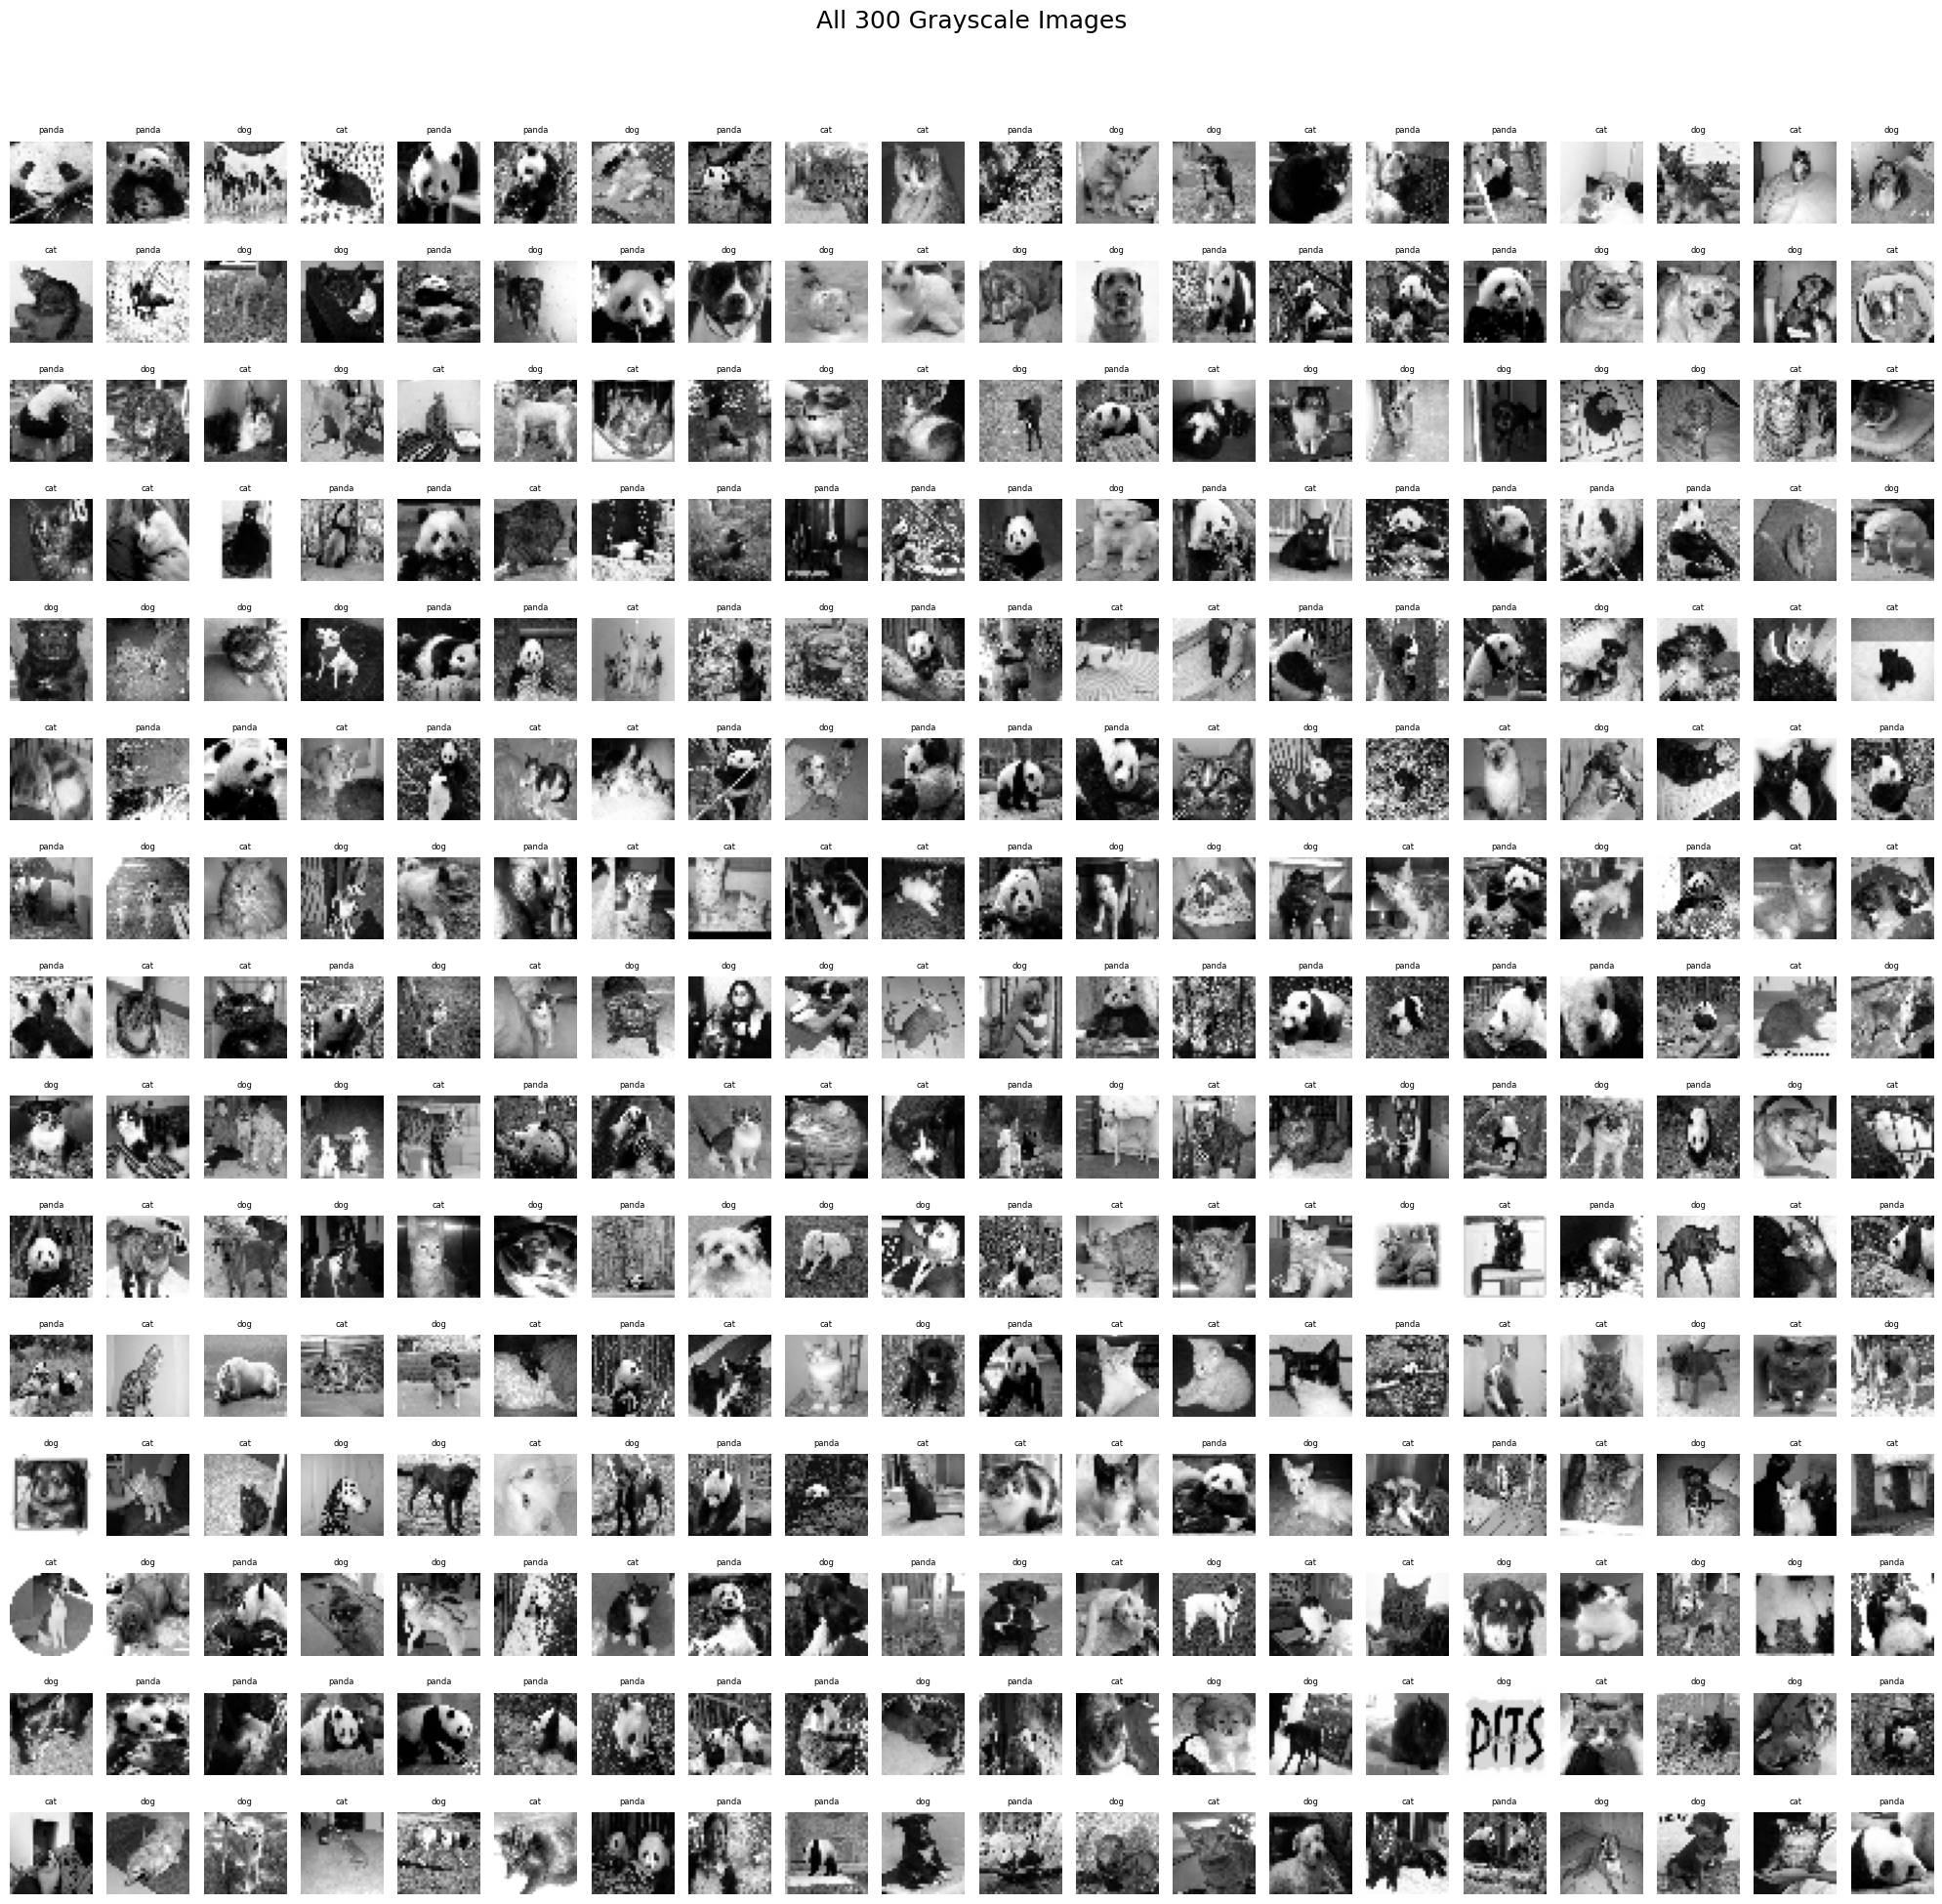

In [9]:

# 3. Display 300 Images
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for i, (img, cls, name) in enumerate(display_data):
    plt.subplot(15, 20, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(cls, fontsize=6)
    plt.axis('off')
plt.suptitle("All 300 Grayscale Images", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


In [10]:

#  kNN Distance
from collections import Counter

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

def knn_predict(X_train, y_train, x_test, k=3, distance_type='L2'):
    distances = []
    for i in range(len(X_train)):
        if distance_type=='L1':
            d = manhattan_distance(X_train[i], x_test)
        else:
            d = euclidean_distance(X_train[i], x_test)
        distances.append((d, y_train[i]))
    distances.sort(key=lambda x: x[0])
    k_labels = [label for _, label in distances[:k]]
    most_common = Counter(k_labels).most_common(1)
    return most_common[0][0]


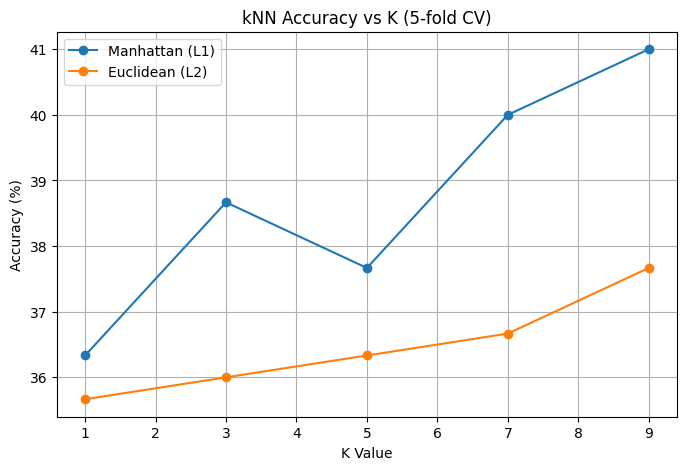

In [11]:

# 5. 5-Fold Cross-Validation

from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
K_values = [1, 3, 5, 7, 9]

def cross_validate(features, labels, distance_type='L2'):
    avg_accuracies = []
    for k in K_values:
        fold_acc = []
        for train_idx, val_idx in kf.split(features):
            X_train, X_val = features[train_idx], features[val_idx]
            y_train, y_val = labels[train_idx], labels[val_idx]
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k=k, distance_type=distance_type)
                correct += (pred == y_val[i])
            fold_acc.append((correct/len(X_val))*100)
        avg_accuracies.append(np.mean(fold_acc))
    return avg_accuracies

# Run cross-validation
acc_L1 = cross_validate(features, labels, distance_type='L1')
acc_L2 = cross_validate(features, labels, distance_type='L2')

# Plot
plt.figure(figsize=(8,5))
plt.plot(K_values, acc_L1, 'o-', label="Manhattan (L1)")
plt.plot(K_values, acc_L2, 'o-', label="Euclidean (L2)")
plt.xlabel("K Value")
plt.ylabel("Accuracy (%)")
plt.title("kNN Accuracy vs K (5-fold CV)")
plt.grid(True)
plt.legend()
plt.show()


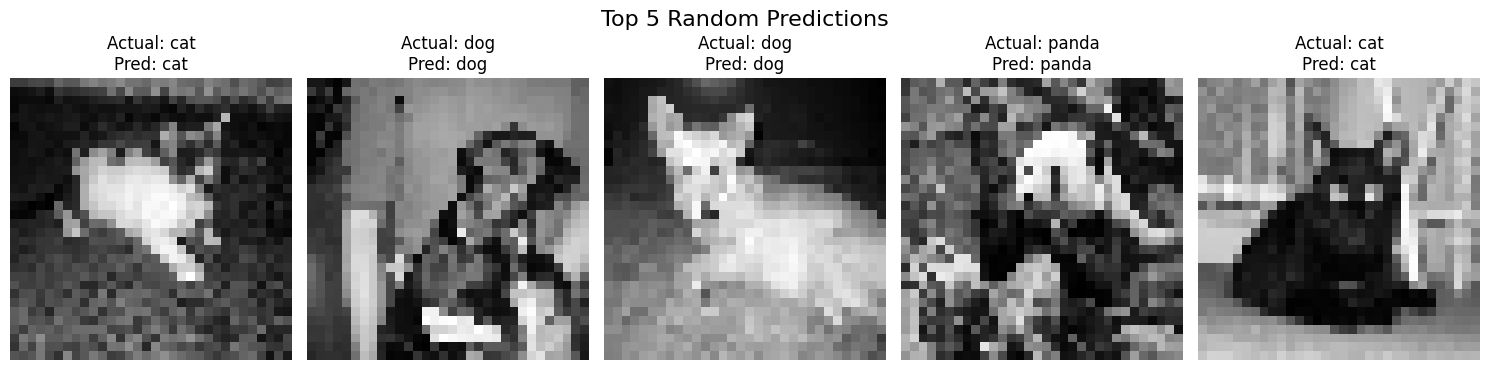

In [ ]:

# 6.  5 Images with Actual & Predicted

import random
plt.figure(figsize=(15,4))

# Pick 5 random images
indices = random.sample(range(len(features)), 5)

for i, idx in enumerate(indices):
    test_img = features[idx]
    test_label = labels[idx]
    pred_label = knn_predict(features, labels, test_img, k=3, distance_type='L2')

    plt.subplot(1, 5, i+1)
    plt.imshow(test_img.reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"Actual: {test_label}\nPred: {pred_label}")
    plt.axis('off')

plt.suptitle("Top 5 Random Predictions", fontsize=16)
plt.tight_layout()
plt.show()


Model Building and Evaluation

We used k-nearest neighbors (k-NN) to classify gray-scale images, testing both Manhattan (L1) and Euclidean (L2) distances. The model was evaluated using 5-fold cross-validation to ensure reliable performance across the dataset.

Results and Analysis

We tested different K values and recorded accuracy for each fold, then calculated the average accuracy. A graph of K vs. accuracy shows how performance changes with K for both distance metrics.

Discussion

Manhattan (L1) and Euclidean (L2) distances performed differently due to dataset characteristics. L1 is better for sparse pixel differences, while L2 is affected more by large intensity variations. Choosing the right K helps balance accuracy and noise sensitivity.